# 01 load libraries

In [1]:
import nitime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Import the time-series objects:
from nitime.timeseries import TimeSeries
from scipy import stats 
# Import the analysis objects:
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.optimize import curve_fit

import networkx as nx
import pywt

/tmp/ipykernel_75588/1208165259.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# 02 draw!

## 2-1 ABCD

/tmp/ipykernel_75588/4000741479.py:52: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(modified_lorentzian_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
/tmp/ipykernel_75588/4000741479.py:142: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_75588/4000741479.py:142: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_75588/4000741479.py:147: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(modified_lorentzian_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


fitted line for ultralow frequency is y=-0.094056x+(0.683673)
fitted line for low frequency is y=-2.085024x+(-2.273986)
fitted line for high frequency is y=-0.701801x+(-1.143214)
fitted line for ultralow frequency is y=0.126955x+(3.297966)
fitted line for low frequency is y=-4.765712x+(-2.295106)
fitted line for high frequency is y=-1.995835x+(0.014613)


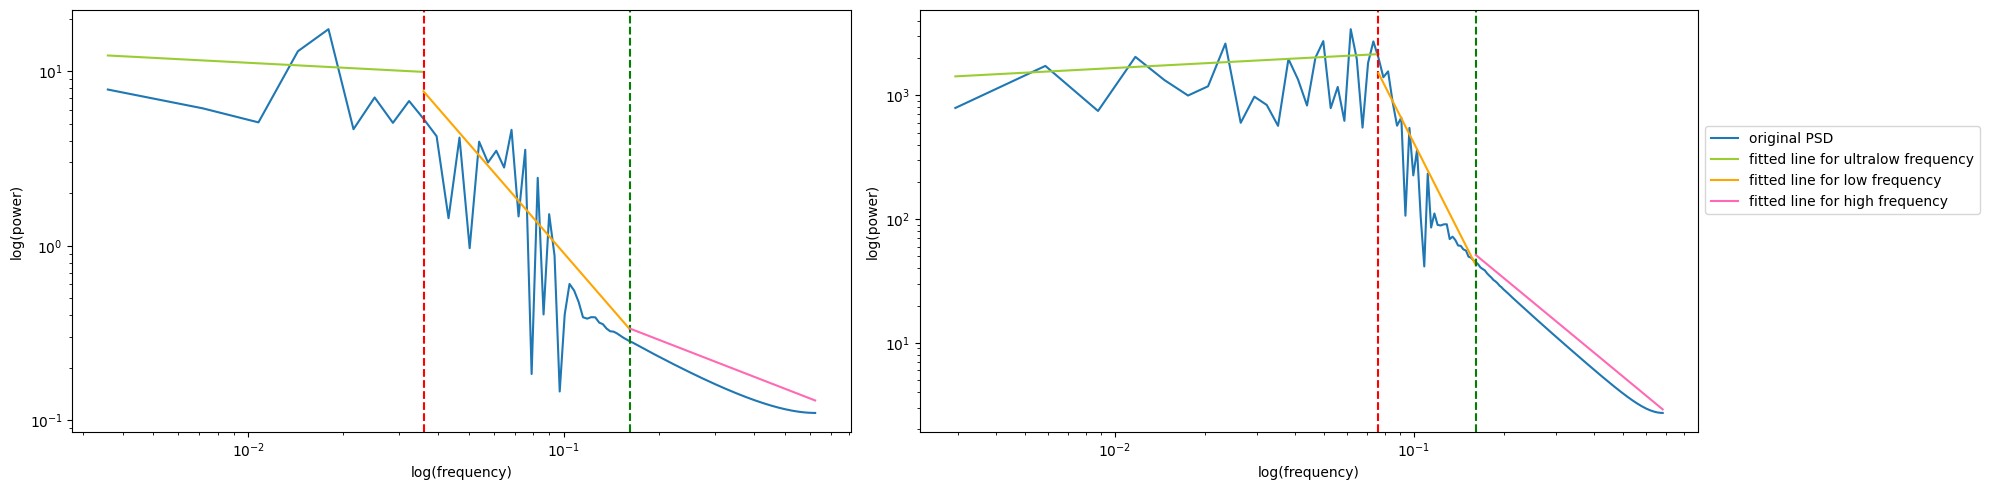

In [4]:
plt.figure(figsize=(20,5))

# 2-1 ABCD
plt.subplot(121)
data_dir = '/scratch/connectome/stellasybae/ABCD_ROI/7.ROI'
sub_list = os.listdir(data_dir)

sub = sub_list[0]
file_dir = os.path.join(data_dir, sub)
file_name = os.path.join(file_dir, 'hcp_mmp1_180_'+sub+'.npy')

y = np.load(file_name)[:348].T

TR = 0.8

sample_whole = np.zeros(348,)

for i in range(180):
    sample_whole+=y[i]

sample_whole /= 180   

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

def lorentzian_function(x, s0, corner):
    return (s0*corner**2) / (x**2 + corner**2)

# 초기 매개변수 설정
p0 = [0, 0.006]

# 로런치안 함수 피팅
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

def modified_lorentzian_function(x, beta_low, beta_high, A, B, corner):
    return np.where(x < corner, A * x**beta_low, B * x**beta_high)
    #return A*x**(-beta_low) / (1+(x/corner)**beta_high)

p1 = [2, 1, 23, 25, 0.16]

popt_mo, pcov = curve_fit(modified_lorentzian_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

plt.loglog(xdata, ydata, label = 'original PSD')


# ultralow : 1 ~ knee+1
x_u = np.log10(S_original.spectrum_fourier[0][1:knee+1])
y_u = np.log10(np.abs(S_original.spectrum_fourier[1])[1:knee+1])
z_u = np.polyfit(x_u, y_u, 1) # (X,Y,차원) 정의
p_u = np.poly1d(z_u) # 1차원 다항식에 대한 연산을 캡슐화

plt.plot(10**x_u, 10**(p_u(x_u))*1.5, color = 'yellowgreen', label='fitted line for ultralow frequency')
print("fitted line for ultralow frequency is y=%.6fx+(%.6f)"%(z_u[0],z_u[1]))

plt.axvline(x=S_original.spectrum_fourier[0][knee], linestyle='--', color='r')

# low : knee ~ pink+1
x_l = np.log10(S_original.spectrum_fourier[0][knee:pink+1])
y_l = np.log10(np.abs(S_original.spectrum_fourier[1])[knee:pink+1])
z_l = np.polyfit(x_l, y_l, 1) # (X,Y,차원) 정의
p_l = np.poly1d(z_l) # 1차원 다항식에 대한 연산을 캡슐화

plt.plot(10**x_l, 10**(p_l(x_l))*1.4, color = 'orange', label='fitted line for low frequency')
print("fitted line for low frequency is y=%.6fx+(%.6f)"%(z_l[0],z_l[1]))

plt.axvline(x=S_original.spectrum_fourier[0][pink], linestyle='--', color='g')


# high : pink ~
x_h = np.log10(S_original.spectrum_fourier[0][pink:])
y_h = np.log10(np.abs(S_original.spectrum_fourier[1])[pink:])
z_h = np.polyfit(x_h, y_h, 1) # (X,Y,차원) 정의
p_h = np.poly1d(z_h) # 1차원 다항식에 대한 연산을 캡슐화

plt.plot(10**x_h, 10**(p_h(x_h))*1.3, color = 'hotpink', label='fitted line for high frequency')
print("fitted line for high frequency is y=%.6fx+(%.6f)"%(z_h[0],z_h[1]))


plt.xlabel('log(frequency)')

plt.ylabel('log(power)')


# 2-2 UKB
plt.subplot(122)
data_dir = '/scratch/connectome/stellasybae/UKB_ROI'
sub_list = os.listdir(data_dir)

sub = sub_list[1]
file_dir = os.path.join(data_dir, sub)
file_name = os.path.join(file_dir, 'hcp_mmp1_'+sub+'.npy')

y = np.load(file_name)[20:20+464].T

TR = 0.735

sample_whole = np.zeros(464,)

for i in range(180):
    sample_whole+=y[i]

sample_whole /= 180   

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])


def lorentzian_function(x, s0, corner):
    return (s0*corner**2) / (x**2 + corner**2)

# 초기 매개변수 설정
p0 = [0, 0.006]

# 로런치안 함수 피팅
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

def modified_lorentzian_function(x, beta_low, beta_high, A, B, corner):
    return np.where(x < corner, A * x**beta_low, B * x**beta_high)
    #return A*x**(-beta_low) / (1+(x/corner)**beta_high)

p1 = [2, 1, 23, 25, 0.16]

popt_mo, pcov = curve_fit(modified_lorentzian_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

plt.loglog(xdata, ydata, label = 'original PSD')


# ultralow : 1 ~ knee+1
x_u = np.log10(S_original.spectrum_fourier[0][1:knee+1])
y_u = np.log10(np.abs(S_original.spectrum_fourier[1])[1:knee+1])
z_u = np.polyfit(x_u, y_u, 1) # (X,Y,차원) 정의
p_u = np.poly1d(z_u) # 1차원 다항식에 대한 연산을 캡슐화

plt.plot(10**x_u, 10**(p_u(x_u))*1.5, color = 'yellowgreen', label='fitted line for ultralow frequency')
print("fitted line for ultralow frequency is y=%.6fx+(%.6f)"%(z_u[0],z_u[1]))

plt.axvline(x=S_original.spectrum_fourier[0][knee], linestyle='--', color='r')

# low : knee ~ pink+1
x_l = np.log10(S_original.spectrum_fourier[0][knee:pink+1])
y_l = np.log10(np.abs(S_original.spectrum_fourier[1])[knee:pink+1])
z_l = np.polyfit(x_l, y_l, 1) # (X,Y,차원) 정의
p_l = np.poly1d(z_l) # 1차원 다항식에 대한 연산을 캡슐화

plt.plot(10**x_l, 10**(p_l(x_l))*1.4, color = 'orange', label='fitted line for low frequency')
print("fitted line for low frequency is y=%.6fx+(%.6f)"%(z_l[0],z_l[1]))

plt.axvline(x=S_original.spectrum_fourier[0][pink], linestyle='--', color='g')


# high : pink ~
x_h = np.log10(S_original.spectrum_fourier[0][pink:])
y_h = np.log10(np.abs(S_original.spectrum_fourier[1])[pink:])
z_h = np.polyfit(x_h, y_h, 1) # (X,Y,차원) 정의
p_h = np.poly1d(z_h) # 1차원 다항식에 대한 연산을 캡슐화

plt.plot(10**x_h, 10**(p_h(x_h))*1.3, color = 'hotpink', label='fitted line for high frequency')
print("fitted line for high frequency is y=%.6fx+(%.6f)"%(z_h[0],z_h[1]))


plt.xlabel('log(frequency)')

plt.ylabel('log(power)')

plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))

plt.tight_layout()
plt.savefig('frequency_dividing.pdf')

plt.show()

## 2-2 UKB

In [11]:
import numpy as np
from scipy import signal

def lorentzian_function(x, constant, f_0, f_low, f_high):
    return (constant*x**(f_low)) / (1+(x/f_0)**f_high)

In [12]:
# plt.figure(figsize=(20,5))

# 2-2 UKB
# plt.subplot(122)
data_dir = '/scratch/connectome/stellasybae/UKB_ROI'
sub_list = os.listdir(data_dir)

sub = sub_list[1]
file_dir = os.path.join(data_dir, sub)
file_name = os.path.join(file_dir, 'hcp_mmp1_'+sub+'.npy')

y = np.load(file_name)[20:20+464].T

TR = 0.735

sample_whole = np.zeros(464,)

for i in range(180):
    sample_whole+=y[i]

sample_whole /= 180   

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# 초기 매개변수 설정
p0 = [100, 0.03, 0.006, 0.15]

# 로런치안 함수 피팅
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f_low = popt[-2]
f_high = popt[-1]

print('f_low', f_low, 'f_high', f_high)

f_low 0.18912611011815483 f_high 21.55728907487431


/tmp/ipykernel_2101699/2813396991.py:5: RuntimeWarning: invalid value encountered in power
  return (constant*x**(f_low)) / (1+(x/f_0)**f_high)


In [5]:
print(f1, f2)

0.1255158598059173 0.1255009337920065


/tmp/ipykernel_2481497/2266738991.py:48: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_2481497/2266738991.py:48: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_2481497/2266738991.py:53: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(modified_lorentzian_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


fitted line for ultralow frequency is y=0.126955x+(3.297966)
fitted line for low frequency is y=-4.765712x+(-2.295106)
fitted line for high frequency is y=-1.995835x+(0.014613)


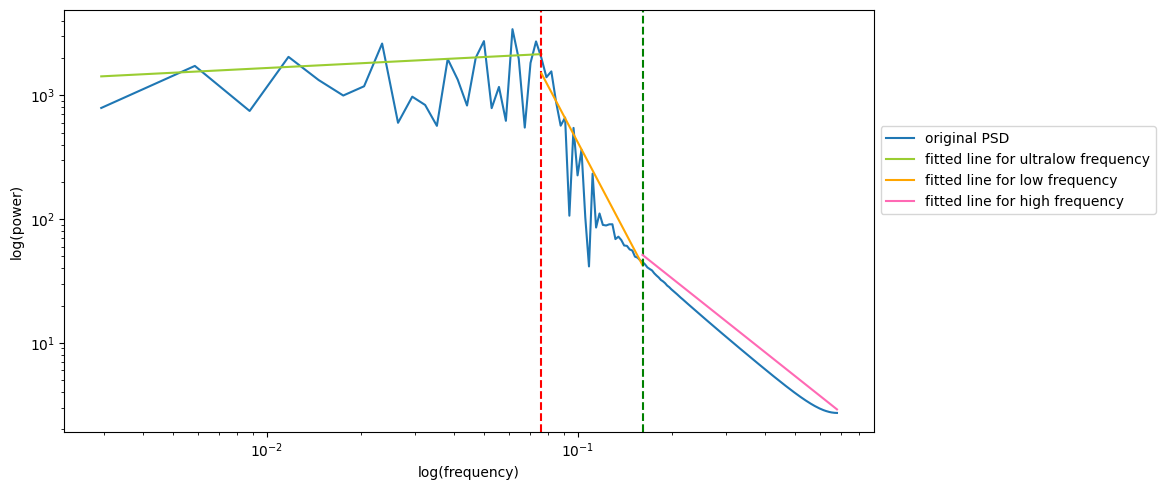

In [2]:
plt.figure(figsize=(20,5))

# 2-2 UKB
plt.subplot(122)
data_dir = '/scratch/connectome/stellasybae/UKB_ROI'
sub_list = os.listdir(data_dir)

sub = sub_list[1]
file_dir = os.path.join(data_dir, sub)
file_name = os.path.join(file_dir, 'hcp_mmp1_'+sub+'.npy')

y = np.load(file_name)[20:20+464].T

TR = 0.735

sample_whole = np.zeros(464,)

for i in range(180):
    sample_whole+=y[i]

sample_whole /= 180   

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

def lorentzian_function(x, constant, f1, f2):
    return constant / ((1+(x/f1)**2) * (1+(x/f2)**2))

# 초기 매개변수 설정
p0 = [0, 0.006, 0.15]

# 로런치안 함수 피팅
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]
f2 = popt[2]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

def modified_lorentzian_function(x, beta_low, beta_high, A, B, corner):
    return np.where(x < corner, A * x**beta_low, B * x**beta_high)
    #return A*x**(-beta_low) / (1+(x/corner)**beta_high)

p1 = [2, 1, 23, 25, 0.16]

popt_mo, pcov = curve_fit(modified_lorentzian_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

plt.loglog(xdata, ydata, label = 'original PSD')


# ultralow : 1 ~ knee+1
x_u = np.log10(S_original.spectrum_fourier[0][1:knee+1])
y_u = np.log10(np.abs(S_original.spectrum_fourier[1])[1:knee+1])
z_u = np.polyfit(x_u, y_u, 1) # (X,Y,차원) 정의
p_u = np.poly1d(z_u) # 1차원 다항식에 대한 연산을 캡슐화

plt.plot(10**x_u, 10**(p_u(x_u))*1.5, color = 'yellowgreen', label='fitted line for ultralow frequency')
print("fitted line for ultralow frequency is y=%.6fx+(%.6f)"%(z_u[0],z_u[1]))

plt.axvline(x=S_original.spectrum_fourier[0][knee], linestyle='--', color='r')

# low : knee ~ pink+1
x_l = np.log10(S_original.spectrum_fourier[0][knee:pink+1])
y_l = np.log10(np.abs(S_original.spectrum_fourier[1])[knee:pink+1])
z_l = np.polyfit(x_l, y_l, 1) # (X,Y,차원) 정의
p_l = np.poly1d(z_l) # 1차원 다항식에 대한 연산을 캡슐화

plt.plot(10**x_l, 10**(p_l(x_l))*1.4, color = 'orange', label='fitted line for low frequency')
print("fitted line for low frequency is y=%.6fx+(%.6f)"%(z_l[0],z_l[1]))

plt.axvline(x=S_original.spectrum_fourier[0][pink], linestyle='--', color='g')


# high : pink ~
x_h = np.log10(S_original.spectrum_fourier[0][pink:])
y_h = np.log10(np.abs(S_original.spectrum_fourier[1])[pink:])
z_h = np.polyfit(x_h, y_h, 1) # (X,Y,차원) 정의
p_h = np.poly1d(z_h) # 1차원 다항식에 대한 연산을 캡슐화

plt.plot(10**x_h, 10**(p_h(x_h))*1.3, color = 'hotpink', label='fitted line for high frequency')
print("fitted line for high frequency is y=%.6fx+(%.6f)"%(z_h[0],z_h[1]))


plt.xlabel('log(frequency)')

plt.ylabel('log(power)')

plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))

plt.tight_layout()
plt.savefig('frequency_dividing.png', 
    dpi=300, 
    facecolor='w', 
    edgecolor='w',
    orientation='portrait', 
    format=None,
    transparent=False, 
    bbox_inches='tight', 
    pad_inches=0.1,
    metadata=None)

plt.show()

In [2]:
def wavelet_corr_mat(signal):
    # signal shape :  (ROI_num, seq_len)

    # wavelet transformation
    coeffs = pywt.dwt(signal, 'db1')  # 'db1' =  Daubechies wavelet
    cA, cD = coeffs  # cA: Approximation Coefficients, cD: etail Coefficients

    return np.corrcoef(cA)

def create_network(correlation_matrix, threshold=0.2):
    # Generate graph whose size is equivalent to correlation matrix
    G = nx.Graph()
    for i in range(correlation_matrix.shape[0]):
        for j in range(i+1, correlation_matrix.shape[1]):
            # add edge when correlation coefficient > threshold.
            if np.abs(correlation_matrix[i, j]) > threshold:
                G.add_edge(i, j)
    return G

In [3]:
def lorentzian_function(x, s0, corner):
    return (s0*corner**2) / (x**2 + corner**2)

def multi_fractal_function(x, beta_low, beta_high, A, B, corner):
    return np.where(x < corner, A * x**beta_low, B * x**beta_high)

In [11]:
sequence_length = 464
intermediate_vec = 180
data_dir = '/scratch/connectome/stellasybae/UKB_ROI'
sub_list = os.listdir(data_dir)

sub = sub_list[1]
file_dir = os.path.join(data_dir, sub)
file_name = os.path.join(file_dir, 'hcp_mmp1_'+sub+'.npy')

y = np.load(file_name)[20:20+sequence_length].T

TR = 0.735
sample_whole = np.zeros(sequence_length,)
for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec    

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]
knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1
# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
f2 = popt_mo[-1]

T1 = TimeSeries(y, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T1)
FA1 = FilterAnalyzer(T1, lb = f2)
high = stats.zscore(FA1.filtered_boxcar.data, axis=1)
ultralow_low = FA1.data-FA1.filtered_boxcar.data

# 02 low ~ ultralow
T2 = TimeSeries(ultralow_low, sampling_interval=TR)
S_original2 = SpectralAnalyzer(T2)
FA2 = FilterAnalyzer(T2, lb=f1)

low = stats.zscore(FA2.filtered_boxcar.data, axis=1)
ultralow = stats.zscore(FA2.data-FA2.filtered_boxcar.data, axis=1)

# high = torch.from_numpy(high).T.float()
# low = torch.from_numpy(low).T.float()
# ultralow = torch.from_numpy(ultralow).T.float()

high_G = create_network(wavelet_corr_mat(high))
high_sigma = nx.sigma(high_G)

low_G = create_network(wavelet_corr_mat(low))
low_sigma = nx.sigma(low_G)

ultralow_G = create_network(wavelet_corr_mat(ultralow))
ultralow_sigma = nx.sigma(ultralow_G)

/tmp/ipykernel_2666124/2577609595.py:5: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_2666124/2577609595.py:5: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_2666124/1644590830.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f54193bea30>>
Traceback (most recent call last):
  File "/home/connectome/stellasybae/.conda/envs/divfreq/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

# 03 ABIDE

In [10]:
data_dir = '/scratch/connectome/stellasybae/ABIDE_ROI'
sub_list = os.listdir(data_dir)
sub_list = [sub[2:] if sub.startswith('00') else sub for sub in sub_list]
abide_180 = open('../splits/ABIDE/ABIDE_ASD_ROI_180_seq_len_280_split1.txt', 'r').readlines()
abide_180 = [x[:-1] for x in abide_180]
abide_180.remove('train_subjects')
abide_180.remove('val_subjects')
abide_180.remove('test_subjects')
valid_sub_list = list(set(sub_list) & set(abide_180))

In [3]:
abide_meta = pd.read_csv('../data/metadata/ABIDE1+2_meta.csv')

In [4]:
abide_meta

,SITE_ID,SUB_ID,DX_GROUP
0,CALTECH,51456,1
1,CALTECH,51457,1
2,CALTECH,51458,1
3,CALTECH,51459,1
4,CALTECH,51460,1
...,...,...,...
1112,BNI_1,29006,1
1113,BNI_1,29007,1
1114,BNI_1,29008,1
1115,BNI_1,29009,1


In [16]:
f1_list = []
f2_list = []
beta_u_list = []
beta_l_list = []
beta_h_list = []

for sub in valid_sub_list:
    site = abide_meta[abide_meta['SUB_ID']==int(sub)]['SITE_ID']

    file_dir = os.path.join(data_dir, sub)
    if os.path.exists(file_dir):
        pass
    else:
        sub = '00'+sub

    file_dir = os.path.join(data_dir, sub)
    file_name = os.path.join(file_dir, 'schaefer_400Parcels_17Networks_'+sub+'.npy')


    if 'CALTECH' in site:
        TR = 2
    elif 'CMU' in site:
        TR = 2
    elif 'KKI' in site:
        TR = 2.5
    elif 'LEUVEN' in site:
        TR = 1.66
    elif 'MAX_MUN' in site:
        TR = 3
    elif 'NYU' in site:
        TR = 2
    elif 'OHSU' in site:
        TR = 2.5
    elif 'OLIN' in site:
        TR = 1.5
    elif 'PITT' in site:
        TR = 1.5
    elif 'SBL' in site:
        TR = 2.2
    elif 'SDSU' in site:
        TR = 2
    elif 'STANFORD' in site:
        TR = 2 
    elif 'TRINITY' in site:
        TR = 2 
    elif 'UCLA' in site:
        TR = 3 
    elif 'UM' in site:
        TR = 2 
    elif 'USM' in site:
        TR = 2
    elif 'YALE' in site:
        TR = 2
    else:
        TR = 3 # ABIDE 2

    y = np.load(file_name)[20:20+280].T

    sample_whole = np.zeros(280,)

    for i in range(400):
        sample_whole+=y[i]

    sample_whole /= 400   

    T = TimeSeries(sample_whole, sampling_interval=TR)
    S_original = SpectralAnalyzer(T)

    # Lorentzian function fitting
    xdata = np.array(S_original.spectrum_fourier[0][1:])
    ydata = np.abs(S_original.spectrum_fourier[1][1:])


    def lorentzian_function(x, s0, corner):
        return (s0*corner**2) / (x**2 + corner**2)

    # 초기 매개변수 설정
    p0 = [0, 0.006]

    # 로런치안 함수 피팅
    popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

    f1 = popt[1]

    knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

    if knee <= 0:
        knee = 1

    def modified_lorentzian_function(x, beta_low, beta_high, A, B, corner):
        return np.where(x < corner, A * x**beta_low, B * x**beta_high)
        #return A*x**(-beta_low) / (1+(x/corner)**beta_high)

    p1 = [2, 1, 23, 25, 0.16]

    popt_mo, pcov = curve_fit(modified_lorentzian_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
    pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
    f2 = popt_mo[-1]


    # ultralow : 1 ~ knee+1
    x_u = np.log10(S_original.spectrum_fourier[0][1:knee+1])
    y_u = np.log10(np.abs(S_original.spectrum_fourier[1])[1:knee+1])
    z_u = np.polyfit(x_u, y_u, 1) # (X,Y,차원) 정의
    p_u = np.poly1d(z_u) # 1차원 다항식에 대한 연산을 캡슐화
    beta_u = z_u[0]

    # low : knee ~ pink+1
    x_l = np.log10(S_original.spectrum_fourier[0][knee:pink+1])
    y_l = np.log10(np.abs(S_original.spectrum_fourier[1])[knee:pink+1])
    z_l = np.polyfit(x_l, y_l, 1) # (X,Y,차원) 정의
    p_l = np.poly1d(z_l) # 1차원 다항식에 대한 연산을 캡슐화

    beta_l = z_l[0]

    # high : pink ~
    x_h = np.log10(S_original.spectrum_fourier[0][pink:])
    y_h = np.log10(np.abs(S_original.spectrum_fourier[1])[pink:])
    z_h = np.polyfit(x_h, y_h, 1) # (X,Y,차원) 정의
    p_h = np.poly1d(z_h) # 1차원 다항식에 대한 연산을 캡슐화

    beta_h = z_h[0]
    
    f1_list.append(f1)
    f2_list.append(f2)
    beta_u_list.append(beta_u)
    beta_l_list.append(beta_l)
    beta_h_list.append(beta_h)

/tmp/ipykernel_1091177/274947244.py:96: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(modified_lorentzian_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
/tmp/ipykernel_1091177/274947244.py:91: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1091177/274947244.py:91: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_1091177/274947244.py:104: RankWarning: Polyfit may be poorly conditioned
  z_u = np.polyfit(x_u, y_u, 1) # (X,Y,차원) 정의
/tmp/ipykernel_1091177/274947244.py:104: RankWarning: Polyfit may be poorly conditioned
  z_u = np.polyfit(x_u, y_u, 1) # (X,Y,차원) 정의
/tmp/ipykernel_1091177/274947244.py:104: RankWarning: Polyfit may be poorly conditioned
  z_u = np.polyfit(x_u, y_u, 1) # (X,Y,차원) 정의
/tmp/ipykernel_1091177/274947244.py:104: RankWarning: Polyfit may be poorly

In [21]:
print('ultralow beta', 'mean', -np.mean(beta_u_list), 'std', np.std(beta_u_list))
print('low beta', 'mean', -np.mean(beta_l_list), 'std', np.std(beta_l_list))
print('high beta', 'mean', -np.mean(beta_h_list), 'std', np.std(beta_h_list))
print('f1', 'mean', np.mean(f1_list), 'std', np.std(f1_list))
print('f2', 'mean', np.mean(f2_list), 'std', np.std(f2_list))

ultralow beta mean 0.5530180459533107 std 0.41720781726854705
low beta mean 1.1691919636616948 std 0.31706303098926175
high beta mean 0.05356258137867359 std 0.00803243256010444
f1 mean 0.007476984187734137 std 0.00989746726566722
f2 mean 0.16 std 0.0
